# Preliminaries
This notebook serves as a simulation exercise for proposition 3.1 of the paper "A Theory of Competition and Exchange innovation: Will the market fix the market? ",  by Budish, Lee and Shim (2023). In this notebook we will try to replicate parts of proposition 3.1, which delineates the equilibrium in which all exchanges will choose to maintain the status quo.

The structure of the notebook is as follows: First, I will implement functions for working out equilibrium spread for the continuation games in which fast TFs will both offer liquidity and take liquidity (Lemma E.1) as well as  for that in which a "lone-wolf" TF will be the sole provider of liquidity (Lemma E.2). Secondly, I will give an example of the spread of the lone wolf and equilibrium TFs for given primitive probabilities and different number of competing fast trading firms and compare these spreads graphicaly. Finally, I will provide unit tests for the important functions involved.



In [3]:
import pandas 
import numpy as np
import jax 
import statistics as stat
import jaxopt
import jax.numpy as jnp

In [4]:
#providing a key for random variables here
key = jax.random.PRNGKey(0)

Lemma E.1: The most fundamental element of the equilibrium is the spread, which is determined by the zero profit condition for trading firms, who provides liquidity and hence determine the spread with their limit orders:
$$ \lambda_{invest} \frac{s^*_{continuous}}{2} = \left( \lambda_{public} + \lambda_{private} \right) L(s^*_{continuous}) $$
where $L()$ represents the loss at being sniped succssfully, with 
$$ L(s) = P(J > s/2)*E(J| J>s/2)$$


The below code calculates equilibrium spread, given primitives like $\lambda_{public}$, $\lambda_{private}$, and $\lambda_{invest}$:

In [89]:
#expected loss

#generate the samples from the distribution, J, of jumps in fundamental value here
#define expected loss from fundamental value changes, given spread s.
def expectedloss(J, s):
    return jnp.array(jax.vmap(lambda x: (x > s/2)*1)(J)).mean()* jax.vmap(lambda x: (x > s/2) * x)(J).mean()


#define expected profits at the spread s: expected 
def expectedprofits(J, s, p_pri, p_pub, l_inv ):
    return l_inv*s/2 - (p_pub + p_pri) * expectedloss(J,s)

#add in rootfinding procedure to find equilibrium s.
def s_star(J, p_pri, p_pub, l_inv, N):
    #we require N>=3 from competitive regulations,
    #if N <= 2:
    #    raise ValueError("Must have no less than 3 TF")
    result = jaxopt.Bisection(lambda s: expectedprofits(J, s, p_pri, p_pub, l_inv), -1,1.)
    eqbm_s = result.run().params
    eqbm_profits = expectedprofits(J,eqbm_s, p_pri, p_pub, l_inv) + p_pub*expectedloss(J, eqbm_s)/N

    #equilibrium spread and profits
    return eqbm_s, eqbm_profits


#example for the jump distributions
J = jax.random.truncated_normal(key, -1, 1, shape = (100,))



In [115]:
s_star(J,0.2,0.3,0.5,3)

(Array(0.21820068, dtype=float32), Array(0.01091269, dtype=float32))

Now we consider lemma E.2 (the lone-wolf lemma ):
The lone-wolf, sole liquidity provider on all exchanges with in the subset $J \subseteq J'$ where $J'$ is the set of exchanges on which all TFs purchased ESST, at the spread $s_N$ such that 
$$\lambda_{invest} \frac{s_N}{2}  - (\frac{N-2}{N-1}\lambda_{public} + \lambda_{private})L(s_N) = \frac{\lambda_{public}L(s_N)}{N}$$
earning a profit $\pi_{lone-wolf} = \lambda_{invest} \frac{s_N}{2}  - (\frac{N-1}{N}\lambda_{public} + \lambda_{private})L(s_N)$. 

Note that the main difference between the equation above which determines equilibrium spread at which lone wolf would offer liquidity and the equation in the previous section that determines the equilibrium spread at which any trading firm would offer liquidity is that there is no opportunity costs from not sniping in the expected loss from liquidity provision.


In [114]:
def Pi_lw(J,s_n, p_pri, p_pub, l_inv, N):
    return l_inv*s_n/2 - ((N-2)/(N-1)*p_pub + p_pri)*expectedloss(J,s_n) 


def pi_lw(J,s_n, p_pub, N):
    return (N-1)/(N^2) * p_pub*expectedloss(J, s_n)
    
def s_lw(J, p_pri, p_pub, l_inv, N): 

    #check number of TF
    #if (N <= 2):
    #    raise ValueError("Must have no less than 3 TF")
    result = jaxopt.Bisection(lambda s: Pi_lw(J, s, p_pri, p_pub, l_inv, N) - p_pub*expectedloss(J,s)/N, -1,1)
    s_n = result.run().params

    #returns eqbm spread and profit for lone wolf 
    return s_n, Pi_lw(J, s_n,p_pri, p_pub, l_inv,N)
def s_min(J, p_pri,p_pub, l_inv, N):
    #check number of TF
    #if N <= 2:
    #    raise ValueError("Must have no less than 3 TF")
    result = jaxopt.Bisection(lambda s: l_inv*s/2 - (N-1)/(N)*(p_pub+ p_pri)*expectedloss(J,s),-1,1)
    s_min = result.run().params

    return s_min
    
s_lw(J,0.2,0.3,0.5,3)


(Array(0.20153809, dtype=float32), Array(0.01119753, dtype=float32))

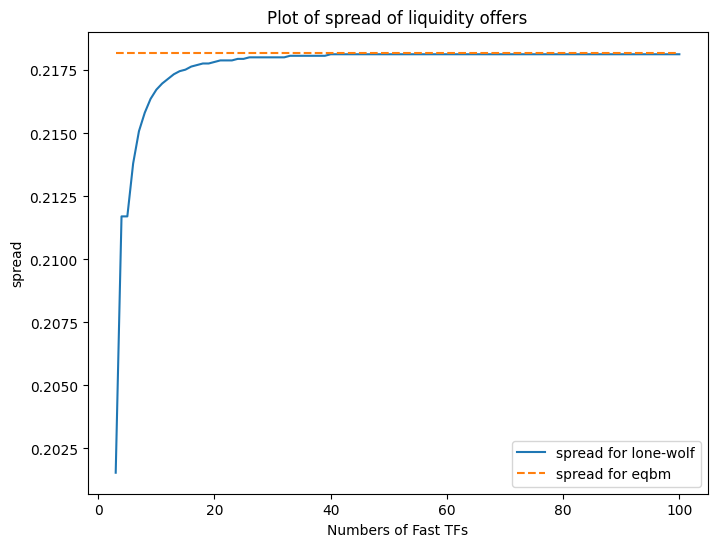

In [119]:
import matplotlib.pyplot as plt
import numpy as np

N = np.linspace(3, 100, 98)

# Evaluate the functions
y1 = []
y2 = []

for n in N:
    y1.append(s_lw(J, 0.2,0.3,0.5,n)[0])
    y2.append(s_star(J, 0.2,0.3,0.5, n)[0])


# Create a 2D plot
plt.figure(figsize=(8, 6))
plt.plot(N, y1, label='spread for lone-wolf')
plt.plot(N, y2, label='spread for eqbm', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Numbers of Fast TFs')
plt.ylabel('spread')
plt.title('Plot of spread of liquidity offers')
plt.legend()

# Show the plot
plt.show()

We can observe that the lone wolf will offer liquidity at relatively lower spread when the number of trading firms are low, and rapidly increase the spread to converge to that of the spread at which equilibrium Fast TF will offer liquidity. One intuitive explanation is that as the number of Fast TFs increase, the probability that the lone wolf will lose a sniping race  also increases, so it will try to extract more profit from the investors to hedge against this increased loss in expectation from sniping.

In [66]:
#testing
import unittest
import jax
from itertools import product


class Test(unittest.TestCase):
    def setUp(self):
        self.key = jax.random.PRNGKey(0)
        self.J = jax.random.truncated_normal(self.key, -1, 1, shape = (100,))

        grid = product(range(0,11),repeat = 3) 
        self.probsimplex = [[p/10 for p in point] for point in grid if (sum(point) == 10)]

    
    def test_Nvalue(self):
        N = 2
        p_pri = 0.3
        p_pub = 0.2
        l_inv = 0.5
        with self.assertRaises(ValueError):
            s_star(self.J, p_pri,p_pub,l_inv,N)



    def test_general_interior(self):
        #testing the general relationship that s_n is smaller than s_continuous 

        #initiate by sample from symmetric distribution with mean 0 and set number of TF
        #J = jax.random.truncated_normal(self.key, -1, 1)
        N = 3
        # create probability simplex

        #testing if s_lw < s_star for all points in the prob simplex created above
        #interior of the simplex
        for i in self.probsimplex:
            if (i[0] == 0) or (i[1] == 0)  or (i[2] == 0):
                continue

            with self.subTest(i = i):
                p_pri = i[0]
                p_pub = i[1]
                l_inv = i[2]
                self.assertTrue(s_star(self.J, p_pri,p_pub,l_inv,N)[0] >= s_lw(self.J, p_pri, p_pub,l_inv, N)[0] >= s_min(J, p_pri, p_pub, l_inv, N))
            

        #border of the simplex
    def test_general_border(self):
        N = 3
        for j in self.probsimplex:
            if (j[0] != 0) and (j[1] != 0)  and (j[2] != 0):
                continue
            with self.subTest(j = j):
                p_pri = j[0]
                p_pub = j[1]
                l_inv = j[2]
                self.assertTrue(s_star(self.J, p_pri,p_pub,l_inv,N)[0] >= s_lw(self.J, p_pri, p_pub,l_inv, N)[0])
                

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False, verbosity = 2)


test_Nvalue (__main__.Test.test_Nvalue) ... ok
test_general_border (__main__.Test.test_general_border) ... 
  test_general_border (__main__.Test.test_general_border) (j=[0.0, 1.0, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.1, 0.9, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.2, 0.8, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.3, 0.7, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.4, 0.6, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.5, 0.5, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.6, 0.4, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.7, 0.3, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.8, 0.2, 0.0]) ... ERROR
  test_general_border (__main__.Test.test_general_border) (j=[0.9, 0.1, 0.0]) ... ERROR
  test_gener

A small detail gathered from this is that $s_N < s_{continuous}$ would not hold in the boundary of the probability simplex. This is somehow omitted from the paper, in both the proofs and the definition. 